# CKAN Site Structure and Harvesting Sample Walkthrough Guide

- This guide will assist users in deconstructing the Comprehensive Knowledge Archive Network (CKAN) site structure and Application Programming Interface (API) design and how they are created through harvesting from selected portals.  
- A simple harvest sample will be presented to simulate the larger process and understand how the harvesting-metadata workflow is done.

## CKAN Site Structure and API Breakdown

### The following is a description of the CKAN API and screenshots of the structure of CKAN sites pertaining to metadata harvesting: 

### CKAN is a tool for making open data websites, it helps you manage and publish collections of data.  For CKAN purposes, data is published in units called “datasets”.

   - A dataset contains two things:

   > Information or “metadata” about the data. For example, the title and publisher, date, what formats it is available in, what license it is released under, etc.

   > A number of “resources”, which hold the data itself. CKAN does not mind what format the data is in. A resource can be a CSV or Excel spreadsheet, XML file, PDF document, image file, linked data in RDF format, etc. CKAN can store the resource internally, or store it simply as a link, the resource itself being elsewhere on the web. A dataset can contain any number of resources. For example, different resources might contain the data for different years, or they might contain the same data in different formats.


## The following screenshots exemplify the site structure of CKAN and then how it is generated for harvesting metadata purposes. 

## This is the Raw site format breakdown for how data is compiled by web notation headers and other indicators in the BTAA format denoted by the harvest.py script for metadata purposes.
### Note, for CKAN it is a series of networks that interlink data units through JSON APIs similar to DCAT but are hosted on storage drives like databases and datastores.
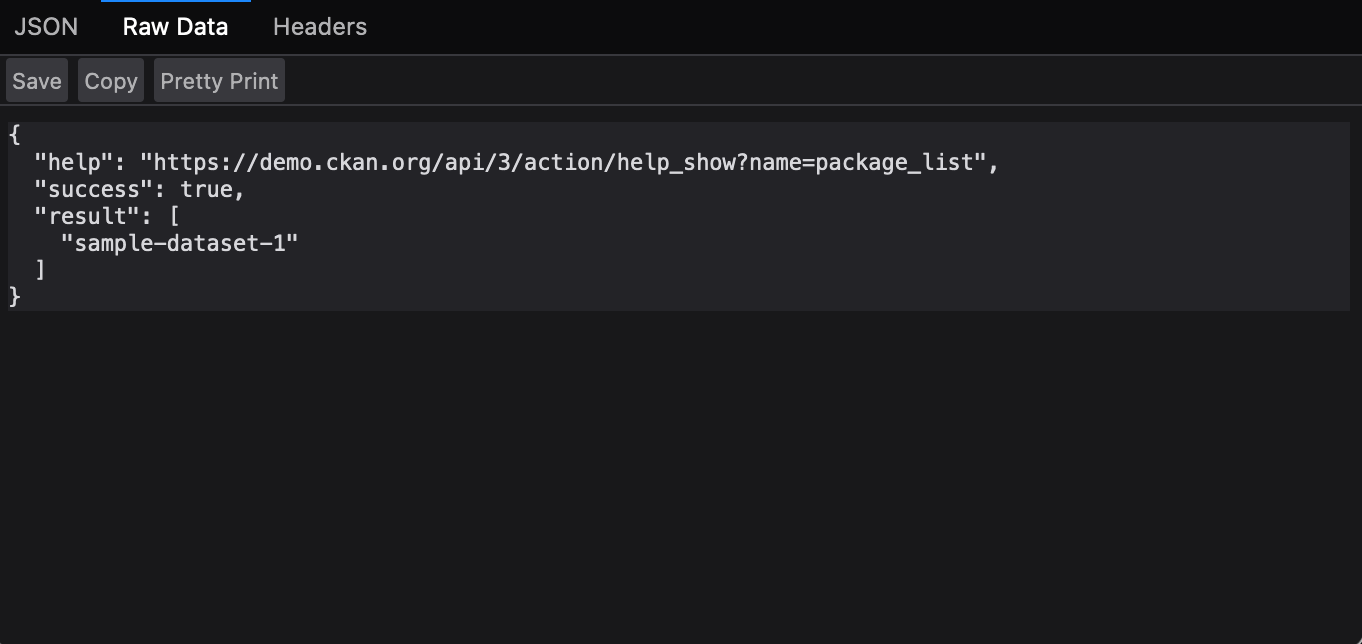

### Only the site/portal would be harvested in this instance and the datastores/databases it contains.

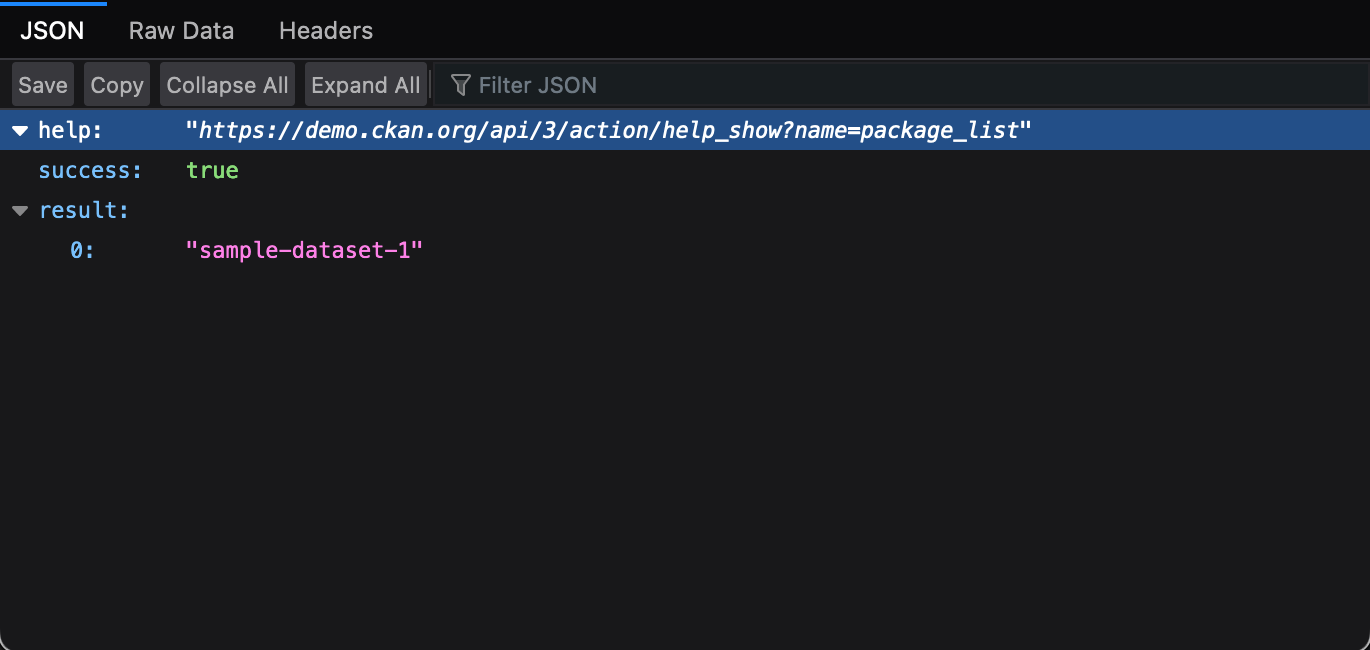

## This section will show samplings of a CKAN harvest and breif selection of site portals sampled:

## 1. Import modules

In [1]:
import csv
import urllib.request
import json 
import time
import os
import pandas as pd
from html.parser import HTMLParser
import re
import ast
import decimal
import ssl
import sys
import numpy as np

In [2]:
# auto-generate the current time in 'YYYYMM' format
actionDate = time.strftime('%Y%m%d')

## 2. Extraction of Portals

In [3]:
portalsInfo = {}

with open('CKANportals.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    
    # jump over the fieldnames
    # loop over from the first content record
    csv_fields = next(reader)
    for row in reader:
        portalsInfo[row[0]] = [row[1], row[2], row[3], row[4], row[5]]


In [11]:
AllNewMetadata = []
AllDeleltedItem = []

for portal in portalsInfo:     
    print()
    print(f'Harvesting portal {portal}')
    
    ### delete later
    if portal == '05d-11':
        print('>>> skip 05d-11')
        continue

    portalURL = portalsInfo[portal][0]
    portalProvider = portalsInfo[portal][1]
    portalPublisher = portalsInfo[portal][2]
    portalSpaCov = portalsInfo[portal][3]

    packageURL = portalURL + 'api/3/action/package_list'
    landingurl = portalURL + 'dataset/'

    # request new resources list
    context = ssl._create_unverified_context()
    response = urllib.request.urlopen(packageURL, context=context).read()
    packageList = json.loads(response.decode('utf-8'))
    newList = packageList['result']

    #store new resources locally for next re-accession
    with open(f'CKAN/{portal}_{actionDate}.csv', 'w') as fw:
        writer = csv.writer(fw)
        field = ['result']
        rows = np.reshape(newList, (-1, 1))
        writer.writerow(field)
        writer.writerows(rows)

    # find the latest resources list
    dates = []
    filenames = os.listdir('CKAN')
    for filename in filenames:
        if filename.startswith(portal):
            dates.append(filename[-12:-4]) 

    if actionDate in dates:
        dates.remove(actionDate)


    # For portals already existed for last re-accession:
    ## compare the current and the latest resources
    ## and find new and deleted items
    if dates:
        oldDate = max(dates)
        oldResource = f'CKAN/{portal}_{oldDate}.csv'

        oldList = []
        with open(oldResource) as fr:
            reader = csv.reader(fr)
            field = next(reader)
            for row in reader:
                oldList.append(row[0])

        newItems = []
        deletedItems = []

        newItems = returnNotMatches(oldList, newList)[0]
        deletedItems = returnNotMatches(oldList, newList)[1]
        AllDeleltedItem += [[portal, x] for x in deletedItems]


    # For new portals:
    # all current resources are new and do not have deleted items
    else:
        newItems = newList


    # Create metadata for all new items for each portal
    withEmpty = []
    metadata = []
    count = 0
    total = len(newItems)

    for item in newItems:
        count += 1
        itemURL = portalURL + 'api/3/action/package_show?id=' + item
        print(f'>>> Collecting dataset({count}/{total}): {itemURL}')

        context = ssl._create_unverified_context()
        response = urllib.request.urlopen(itemURL, context=context).read()
        newitem = json.loads(response.decode('utf-8'))
        #withEmpty.append(metadataNewItems(newitem))

    # check whether empty
    metadata = [x for x in withEmpty if x != []]
    AllNewMetadata += metadata 


Harvesting portal 05a-01
>>> Collecting dataset(1/1017): https://gisdata.mn.gov/api/3/action/package_show?id=agri-agbmp-loans
>>> Collecting dataset(2/1017): https://gisdata.mn.gov/api/3/action/package_show?id=agri-agroecoregions
>>> Collecting dataset(3/1017): https://gisdata.mn.gov/api/3/action/package_show?id=agri-app-fall-fert-restrictions
>>> Collecting dataset(4/1017): https://gisdata.mn.gov/api/3/action/package_show?id=agri-app-food-for-thought-maps
>>> Collecting dataset(5/1017): https://gisdata.mn.gov/api/3/action/package_show?id=agri-bah-field-staff
>>> Collecting dataset(6/1017): https://gisdata.mn.gov/api/3/action/package_show?id=agri-cropland-data-layer-2006
>>> Collecting dataset(7/1017): https://gisdata.mn.gov/api/3/action/package_show?id=agri-cropland-data-layer-2007
>>> Collecting dataset(8/1017): https://gisdata.mn.gov/api/3/action/package_show?id=agri-cropland-data-layer-2008
>>> Collecting dataset(9/1017): https://gisdata.mn.gov/api/3/action/package_show?id=agri-cr

KeyboardInterrupt: 

## 3. Print Reports

In [ ]:
def printReport(report, fields, datalist):
    with open(report, 'w', newline='', encoding='utf-8') as f:
        csvout = csv.writer(f)
        csvout.writerow(fields)
        csvout.writerows(datalist)

In [ ]:
fieldnames_new = ['Title', 'Alternative Title', 'Description', 'Language', 'Creator', 'titleSource', 'Resource Class',
              'Theme', 'Keyword', 'Date Issued', 'Temporal Coverage', 'Date Range', 'Spatial Coverage',
              'Bounding Box', 'Resource Type', 'Format', 'Information', 'Download', 'MapServer', 
              'FeatureServer', 'ImageServer', 'HTML', 'Image', 'ID', 'Identifier', 'Provider', 'Code', 'Member Of', 
              'Is Part Of', 'Status', 'Accrual Method', 'Date Accessioned', 'Rights', 'Access Rights', 'Suppressed', 'Child Record']

filepath_new = f'reports/allNewItems_{actionDate}.csv'   
printReport(filepath_new, fieldnames_new, AllNewMetadata)